# Exploring works in SAX

In this notebook, we will explore the works in SAX. This exploration was done in the end of Q3 for a SAX deduplication exercise, which we did using the [adhoc_matching](http://bitbucket.kobaltmusic.com:7990/projects/DATA/repos/riverdeep-proc-matching-adhoc/browse) tool.

The works and relevant information (e.g. recordings, interested parties) have been fetched from SAX, joined, transformed and saved to s3 in the appropriate JSON format, required by `adhoc_matching`.

Below we will:
1. Load the data to `pandas`
2. Investigate how complete the work metadata is (both columns and rows)
3. Investigate how unique the values are

In [1]:
import os
import logging

import boto3
import pandas as pd

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline


## Start logger

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
logger.setLevel(logging.INFO)
logger.info("Started logger")

INFO:__main__:Started logger


## Define variables and paths

In [3]:
bucket = "ktech-data-science-sagemaker"
task_folder = os.path.join('adhoc_matching', "sprint38-ds2085-kosax_work_deduplication")


s3 = boto3.client('s3')
key = os.path.join(task_folder, "works_flattened.json")
work_content_object = s3.get_object(Bucket=bucket, Key=key)


INFO:botocore.credentials:Found credentials in environment variables.


# Read works

In [4]:
logger.info("Reading from s3://%s", os.path.join(bucket, key))
works_df = pd.read_json(work_content_object['Body'], lines=True)

display(works_df.head())
logging.info("Read %d works", len(works_df))

INFO:__main__:Reading from s3://ktech-data-science-sagemaker/adhoc_matching/sprint38-ds2085-kosax_work_deduplication/works_flattened.json


,work_id,primary_title,duplicate_work_preferred_id,alternative_titles,artist_ids,artist_names,writer_party_ids,writer_ipi_numbers,writer_fullnames,writer_alternative_names,recording_titles,recording_artist_ids,recording_artist_names
0,WK3686,When I Grow Up I Want To Be...,None,None,[ART24550],[Television Personalities],[IP1815],None,[Daniel Treacy],None,[When I Grow Up I Want To Be.],[ART24550],[Television Personalities]
1,WK3376,Ela' Do (Come To Me),None,None,[ART12290],[Antique],"[IP1716, IP473, IP443]",[271027494],"[Andreas Unge, Lidia Papaconstantinou, Alexand...",None,[Ela' Do],[ART12290],[Antique]
2,WK3379,All Your Love,None,None,None,None,"[IP443, IP5]","[249808432, 271027494]","[Peter Johan Jeff Jr Cartriers, Alexander Dimi...",None,[All Your Love],None,None
3,WK3385,Healing Hands,None,None,None,None,[IP416],[291747829],[Andreas Per Kleerup],None,[Healing Hands],None,None
4,WK939801,Osekere,None,None,[ART65841],[Tunji Oyelana],[IP261890],None,[Tunji Oyelana],None,[Osekere],[ART65841],[Tunji Oyelana]


INFO:root:Read 804528 works


# Explore `work_id`s

We expect the `work_id`s to be complete and unique. They must adhere to `WK + integer` format. Let's see if it's indeed the case...

In [5]:
logger.info("%s%% work_id's are filled.",
            100 * works_df.work_id.count() / len(works_df))
logger.info("%s%% work_id's are unique.",
            100 * works_df.work_id.nunique() / len(works_df))

if not works_df.work_id.str.match("^(WK)[0-9]+$", na=False).all():
    logger.error("Invalid work_id's!")

INFO:__main__:100.0% work_id's are filled.
INFO:__main__:100.0% work_id's are unique.


Just as expected! Let's convert the `work_id` column to an index.

In [6]:
works_df.set_index('work_id', inplace=True, drop=False)
display(works_df.head())

,work_id,primary_title,duplicate_work_preferred_id,alternative_titles,artist_ids,artist_names,writer_party_ids,writer_ipi_numbers,writer_fullnames,writer_alternative_names,recording_titles,recording_artist_ids,recording_artist_names
work_id,,,,,,,,,,,,,
WK3686,WK3686,When I Grow Up I Want To Be...,None,None,[ART24550],[Television Personalities],[IP1815],None,[Daniel Treacy],None,[When I Grow Up I Want To Be.],[ART24550],[Television Personalities]
WK3376,WK3376,Ela' Do (Come To Me),None,None,[ART12290],[Antique],"[IP1716, IP473, IP443]",[271027494],"[Andreas Unge, Lidia Papaconstantinou, Alexand...",None,[Ela' Do],[ART12290],[Antique]
WK3379,WK3379,All Your Love,None,None,None,None,"[IP443, IP5]","[249808432, 271027494]","[Peter Johan Jeff Jr Cartriers, Alexander Dimi...",None,[All Your Love],None,None
WK3385,WK3385,Healing Hands,None,None,None,None,[IP416],[291747829],[Andreas Per Kleerup],None,[Healing Hands],None,None
WK939801,WK939801,Osekere,None,None,[ART65841],[Tunji Oyelana],[IP261890],None,[Tunji Oyelana],None,[Osekere],[ART65841],[Tunji Oyelana]


# Compute completeness

First, we will investigate how complete the work metadata is. Basically, the more **complete** the metadata is, the **easier** it will be deduplicate. 

We can check completeness from two facets: *column-wise* and *row-wise*. They would convey how complete each field is and how the well the information about each work is populated, respectively.


## Column completeness

First, we will compute the completeness for all columns. We can automate the computation by defining a `get_completeness` method and applying it to the dataframe.

In [7]:
def get_completeness(series: pd.Series) -> int:
    return series.count() / len(series)


work_id                        1.000000
primary_title                  1.000000
duplicate_work_preferred_id    0.009046
alternative_titles             0.095536
artist_ids                     0.364018
artist_names                   0.364018
writer_party_ids               0.993198
writer_ipi_numbers             0.897276
writer_fullnames               0.993198
writer_alternative_names       0.153146
recording_titles               0.993718
recording_artist_ids           0.368107
recording_artist_names         0.368107
dtype: float64

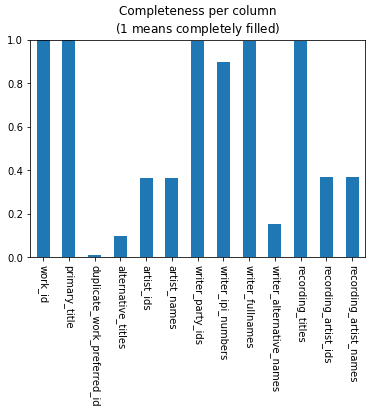

In [8]:
col_completeness = works_df.apply(get_completeness)
display(col_completeness)

# bar plot
col_completeness.plot.bar(ylim=[0, 1], rot=-90)
plt.title("Completeness per column\n($1$ means completely filled)")
plt.show()


## Row completeness (by sampling)

Next, we would also like to compute how complete the information about each instance of work metadata is. We apply the same method to rows by specifying the `axis` in the `apply` function, and then we draw a histogram to obtain a distribution of row-completeness.

__Note:__ If we compute the completeness for each work, it will be too slow. Instead, we randomly sample the works to get an approximate completeness of the whole dataset.

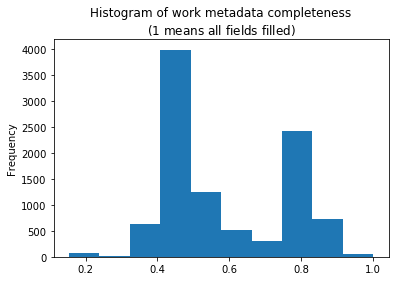

In [9]:
row_completeness = (works_df
                    .sample(10000)
                    .apply(get_completeness, axis=1))


row_completeness.plot.hist()
plt.title("Histogram of work metadata completeness\n($1$ means all fields filled)")
plt.show()

# Compute uniqueness

Let's also compute the uniqueness, just like above! *Uniqueness* would give us an understanding of how useful a field would be to distinguish the correct matches.

A field with a low *uniqueness* would not be very useful as it will produce many candidates. You may consider such fields role similar to filters would function.

Field with a high *uniqueness* value are typically the best for matching. Note that index fields (like `work_id`) would be completely unique: if you can utilize them, you don't need to do matching at all since the problem reduces to **joining tables**.

In [10]:
def get_uniqueness(series: pd.Series) -> int:
    return series.nunique() / len(series)

In [11]:
try:
    col_uniqueness = works_df.apply(get_uniqueness)
    display(col_uniqueness)
except TypeError as err:
    logger.error(err)

display(works_df.head())

ERROR:__main__:("unhashable type: 'list'", 'occurred at index alternative_titles')


,work_id,primary_title,duplicate_work_preferred_id,alternative_titles,artist_ids,artist_names,writer_party_ids,writer_ipi_numbers,writer_fullnames,writer_alternative_names,recording_titles,recording_artist_ids,recording_artist_names
work_id,,,,,,,,,,,,,
WK3686,WK3686,When I Grow Up I Want To Be...,None,None,[ART24550],[Television Personalities],[IP1815],None,[Daniel Treacy],None,[When I Grow Up I Want To Be.],[ART24550],[Television Personalities]
WK3376,WK3376,Ela' Do (Come To Me),None,None,[ART12290],[Antique],"[IP1716, IP473, IP443]",[271027494],"[Andreas Unge, Lidia Papaconstantinou, Alexand...",None,[Ela' Do],[ART12290],[Antique]
WK3379,WK3379,All Your Love,None,None,None,None,"[IP443, IP5]","[249808432, 271027494]","[Peter Johan Jeff Jr Cartriers, Alexander Dimi...",None,[All Your Love],None,None
WK3385,WK3385,Healing Hands,None,None,None,None,[IP416],[291747829],[Andreas Per Kleerup],None,[Healing Hands],None,None
WK939801,WK939801,Osekere,None,None,[ART65841],[Tunji Oyelana],[IP261890],None,[Tunji Oyelana],None,[Osekere],[ART65841],[Tunji Oyelana]


Opps, some of the columns have `list` of `string`s. In Python lists are not hashable, hence we cannot compute number of unique values.

Let's convert the `list`s to `frozenset`, and then re-run the uniqueness computation

In [12]:
def to_frozenset(val: [list, None]) -> [list, None]:
    if val is None:
        return val
    elif isinstance(val, list):
        return frozenset(val)
    else:
        return val


In [13]:
for col in tqdm_notebook(works_df.columns):
    logger.info("Converting %s ", col)
    works_df[col] = works_df[col].apply(to_frozenset)
    
works_df.head()    

INFO:__main__:Converting work_id 
INFO:__main__:Converting primary_title 
INFO:__main__:Converting duplicate_work_preferred_id 
INFO:__main__:Converting alternative_titles 
INFO:__main__:Converting artist_ids 
INFO:__main__:Converting artist_names 
INFO:__main__:Converting writer_party_ids 
INFO:__main__:Converting writer_ipi_numbers 
INFO:__main__:Converting writer_fullnames 
INFO:__main__:Converting writer_alternative_names 
INFO:__main__:Converting recording_titles 
INFO:__main__:Converting recording_artist_ids 
INFO:__main__:Converting recording_artist_names 


,work_id,primary_title,duplicate_work_preferred_id,alternative_titles,artist_ids,artist_names,writer_party_ids,writer_ipi_numbers,writer_fullnames,writer_alternative_names,recording_titles,recording_artist_ids,recording_artist_names
work_id,,,,,,,,,,,,,
WK3686,WK3686,When I Grow Up I Want To Be...,None,None,(ART24550),(Television Personalities),(IP1815),None,(Daniel Treacy),None,(When I Grow Up I Want To Be.),(ART24550),(Television Personalities)
WK3376,WK3376,Ela' Do (Come To Me),None,None,(ART12290),(Antique),"(IP1716, IP443, IP473)",(271027494),"(Alexander Dimitrej Papaconstantinou, Lidia Pa...",None,(Ela' Do),(ART12290),(Antique)
WK3379,WK3379,All Your Love,None,None,None,None,"(IP443, IP5)","(249808432, 271027494)","(Peter Johan Jeff Jr Cartriers, Alexander Dimi...",None,(All Your Love),None,None
WK3385,WK3385,Healing Hands,None,None,None,None,(IP416),(291747829),(Andreas Per Kleerup),None,(Healing Hands),None,None
WK939801,WK939801,Osekere,None,None,(ART65841),(Tunji Oyelana),(IP261890),None,(Tunji Oyelana),None,(Osekere),(ART65841),(Tunji Oyelana)


work_id                        1.000000
primary_title                  0.653893
duplicate_work_preferred_id    0.008801
alternative_titles             0.089952
artist_ids                     0.051103
artist_names                   0.051096
writer_party_ids               0.284108
writer_ipi_numbers             0.172639
writer_fullnames               0.280384
writer_alternative_names       0.008410
recording_titles               0.677729
recording_artist_ids           0.060168
recording_artist_names         0.060162
dtype: float64

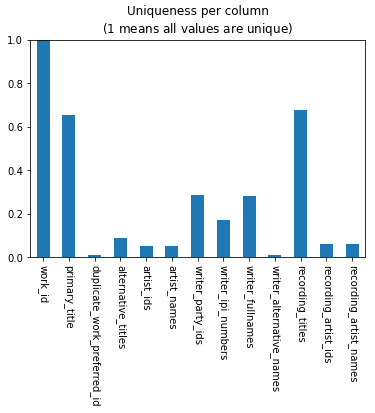

In [14]:
col_uniqueness = works_df.apply(get_uniqueness)
display(col_uniqueness)

# bar plot
col_uniqueness.plot.bar(ylim=[0, 1], rot=-90)
plt.title("Uniqueness per column\n($1$ means all values are unique)")
plt.show()

Looks like *title-related* fields are around 65% unique. Titles (as expected) would probably yield the most useful, followed by *writer-related* fields. It's a question whether, `alternative_titles`, and *(recording) artist-related* fields will be of any use.

# Inspect title and writer related fields

These fields seem to be the most suitable. Let's start with inspecting the `primary_title`:

## Inspect primary title

Let's list the common titles. This would give us some expectations about the [term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (TF-IDF) scores.

In [15]:
works_df.primary_title.value_counts().head(50)

Intro           444
Home            357
Hold On         257
Stay            240
Without You     220
Shine           202
You             201
Tonight         199
Fire            196
Time            194
Free            192
Forever         187
Silent Night    184
Paradise        179
Runaway         177
Lost            169
Goodbye         166
Closer          165
Falling         164
Heaven          163
Beautiful       161
Let It Go       160
Alive           159
Crazy           159
Wake Up         159
Run             158
Higher          155
Tell Me         154
Waiting         153
Love            152
Sunshine        152
Trouble         152
Angel           151
Gone            151
Breathe         148
Everything      148
Surrender       145
Together        145
Sometimes       144
Save Me         140
Ghost           139
Alone           138
The One         137
Smile           137
Hurricane       136
Someday         136
Go              133
Change          132
Why             132
Believe         130


Many consist of quite common words or themes. Next, let's get the word counts in the titles.

In [16]:
display(works_df
        .primary_title
        .str.split(expand=True)
        .stack()
        .value_counts())

The             87875
You             42034
I               31091
A               31057
Of              30712
                ...  
Phornography        1
CeCe                1
Bread)              1
Homefree            1
272218              1
Length: 157808, dtype: int64

As expected, many of the words are English [stop words](https://en.wikipedia.org/wiki/Stop_words). We would expect hits with the stop words to produce a low score. However, a better option may be removing these words from TF-IDF computations all together (*when meaningful)...

## Inspect `alternative_titles`

Now let's do the above analysis to `altenative_titles` field and check if we could obtain any meaningful information to aid matching.

In [17]:
display(works_df.alternative_titles.value_counts().head(50))


(Heidi Soundtrack)                                      47
(RUSH - CUES)                                           42
(Cracks Soundtrack)                                     28
(Timber Falls Soundtrack)                               24
(P.S. I Love You Soundtrack Album)                      24
(The Woman In Black Soundtrack Album)                   22
(A Map Of The World)                                    22
(The Blind Side Soundtrack Album)                       21
(Lemon Sky)                                             21
(Malice In Wonderland Soundtrack)                       20
(The Oprah Winfrey Show (Six Years Later - The Chil)    20
(Racing Stripes Soundtrack Album)                       20
(Sisterhood Of The Traveling Pants Soundtrack Album)    20
(JACKIE - FILM CUES)                                    19
(Black Death Soundtrack)                                19
(Dolphin Tale Soundtrack Album)                         19
(Cougar Town - Cues)                                    

`alternative_titles` have many words related to music terminology, e.g. *album, soundtrack*. Trying to use this field in matching might increase confusion due to common word hits.

## Inspect number of writers

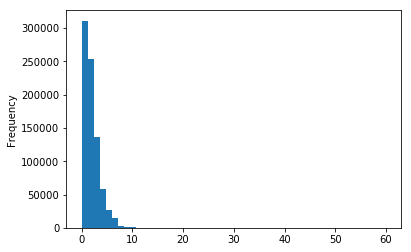

count    804528.000000
mean          2.142097
std           1.356352
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          60.000000
Name: num_writers, dtype: float64

In [18]:
def num_elements(fset: [frozenset, None]) -> int:
    try:
        return len(fset)
    except TypeError:
        return 0

works_df["num_writers"] = works_df.writer_party_ids.apply(num_elements)

works_df["num_writers"].plot.hist(bins=50)
plt.show()

display(works_df["num_writers"].describe())

As we have seen before we have writers populated for practically every work!

Apart from that we can observe that works typically have around 2 writers. The number decays exponentially until practically vanishing around 10 writers.

But there is also a work with 60 writers. How is it possible? Is it an outlier of some sort? 🤔

In [19]:
works_df[works_df.num_writers > 20].sort_values(by="num_writers",
                                                ascending=False)

,work_id,primary_title,duplicate_work_preferred_id,alternative_titles,artist_ids,artist_names,writer_party_ids,writer_ipi_numbers,writer_fullnames,writer_alternative_names,recording_titles,recording_artist_ids,recording_artist_names,num_writers
work_id,,,,,,,,,,,,,,
WK969501,WK969501,Polka Face,None,None,(ART26427),(Weird Al Yankovic),"(IP49114, IP1824, IP48422, IP60071, IP215353, ...","(342943558, 519491140, 505203404, 519338344, 3...","(David Wesley Haywood, Alecia Beth Moore, Ralp...","(, Adetayo Ayowale Onile-Ere, Charles B Kelley...",(Polka Face),(ART26427),(Weird Al Yankovic),60
WK1735560,WK1735560,NOW That's What I Call Polka,None,None,(ART26427),(Weird Al Yankovic),"(IP325152, IP362533, IP28027, IP124279, IP2679...","(261873943, 432849348, 486473119, 335508470, 5...","(Ryan Scott Lewis, Arthur Richardson, Stefan G...","(Williams Pharrell L, Pitbull, GoonRock, Julia...","(NOW That's What I Call Polka, NOW That's What...","(ART161962, ART26427)","(""Weird Al"" Yankovic, Weird Al Yankovic)",43
WK2473409,WK2473409,World Championship Finale 2,None,None,(ART95803),(The Barden Bellas),"(IP325152, IP405514, IP314043, IP536645, IP215...","(612805570, 580851239, 341826274, 527142275, 4...","(Lee Oskar, Sia Furler, Tove Lo, Bob Crewe, Th...","(Mike Caren, AfroJack, Pitbull, Robert Crewe, ...",(World Championship Finale 2),(ART95803),(The Barden Bellas),41
WK700974,WK700974,Latinos Unidos,None,None,None,None,"(IP128727, IP128741, IP33511, IP128717, IP1287...","(87329740, 13329908, 41392500, 141682190, 7327...","(Kevin Duane Mc Cord, Bill 1 Jones, A Gorie, R...",(Flea),(Latinos Unidos),None,None,30
WK766220,WK766220,Best Disco In Town,None,None,None,None,"(IP26587, IP26588, IP57373, IP30379, IP232873,...","(77822939, 54423005, 86365938, 77786222, 63305...","(Rick Finch, Stephan Prager, Jacques Morali, O...",(Robert Crewe),(Best Disco In Town),None,None,28
WK2371922,WK2371922,Eighties,None,"(Eighties A Decade Of Hits, The Eighties, Deca...",None,None,"(IP471694, IP471714, IP59726, IP138306, IP4717...","(41379588, 65250000, 57447362, 63556667, 59926...","(John T Williams, Robert S Rans, Keith Forsey,...",None,(Eighties),None,None,28
WK2371606,WK2371606,Behind Closed Doors,None,None,(ART205444),(WC and the MAAD Circle),"(IP55718, IP55713, IP55719, IP58020, IP35438, ...","(333985635, 63507684, 128443479, 42004441, 128...","(Gregory E Jacobs, William L Calhoun, Andre Ro...",(Ice Cube),(Behind Closed Doors),(ART205444),(WC and the MAAD Circle),25
WK2438136,WK2438136,Break 'Em Off Something Proper,None,(BREAK THEM OFF SOMETHING PROPER),None,None,"(IP519882, IP516357, IP522221, IP514244, IP513...","(179401362, 129097657, 179396316)","(Larry Troutman, Dexter Ansley, William L Calh...",None,(Break 'Em Off Something Proper),None,None,24
WK831296,WK831296,Super High,None,None,(ART22688),(Rick Ross feat. Ne-Yo),"(IP70448, IP57380, IP55718, IP55713, IP55719, ...","(75899608, 578130048, 61650790, 63507684, 1284...","(Steven R Arrington, William Edward De Vaughn,...","(Ice Cube, Ne-Yo, Rick Ross)",(Super High),(ART22682),(Rick Ross),23


Hmm, what is that Polka face song? Let's search online!

In [20]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/MRJILK3NxSM" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Additional reads

## Blogs

1. [Python Data Profiling in DataCamp](https://www.datacamp.com/community/tutorials/python-data-profiling)
2. [Data Exploration with Python in Kaggle](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
3. [Guide to Data Exploration in Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/)

## Exploration tools

1. [pandas-profiling for Python/pandas](https://github.com/pandas-profiling/pandas-profiling)
2. [Deequ for Scala/Spark](https://aws.amazon.com/blogs/big-data/test-data-quality-at-scale-with-deequ/)

## Videos/Online courses

1. [Data Visualization and Exploration with Python in PyData 2017](https://www.youtube.com/watch?v=KvZ2KSxlWBY)
2. [Machine Learning With Big Data in Coursera](https://www.coursera.org/lecture/big-data-machine-learning/data-exploration-eTMKY)

## Online graduate-level courses

1. [Data Cleaning and Integration in Duke University](https://sites.duke.edu/compsci590_01_s2017/schedule/)
2. [Data Science: Principles, Algorithms, and Applications in University of Wisconsin-Madison](https://sites.google.com/site/anhaidgroup/courses/cs-838-spring-2019)